In [83]:
import torch
from model import FNN,LossFNN,LossFNNSwish
import os
import numpy as np
import joblib
import math
from  tqdm import tqdm 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec


In [6]:
l_N = 60   # lengthscale对的数量
k_ ='rbf'
nx = 32
ny = 32
num_samples = 100   # 每个随机场采样的样本数
datadir = "/home/huangjg/MyFiles/deep-uq-paper/data"

In [13]:


cellcentersFile = "cellcenters_"+"nx_"+str(nx)+"_"+str(ny)+".pkl"
cellcenters = joblib.load(os.path.join(datadir,cellcentersFile))
# TrainDataFile = k_+"_l_N_"+str(l_N)+"_num_samples_"+str(num_samples)+\
#                     "_nx_"+str(nx)+"_ny_"+str(ny)+"_train.pkl"

# TrainData = joblib.load(os.path.join(datadir,TrainDataFile))

train_mean_label,train_std_label = joblib.load("norm_std.pkl")

print("数据加载成功！")

数据加载成功！


In [7]:
AllDataFile = k_+"_l_N_"+str(100)+"_num_samples_"+str(num_samples)+\
                    "_nx_"+str(nx)+"_ny_"+str(ny)+"_val.pkl"

Val_all_data = joblib.load(os.path.join(datadir,AllDataFile))
print("数据加载成功！")

数据加载成功！


In [23]:
# 模型加载
MyModel = FNN(1026,7,2)
save_model_name = k_+"_l_N_"+str(l_N)+"_num_samples_"+str(num_samples)+\
                    "_nx_"+str(nx)+"_ny_"+str(ny)+"_train_meta.pth"
MyModel.load_state_dict(torch.load(os.path.join("/home/huangjg/MyFiles/deep-uq-paper/torch","pth",save_model_name)) ) #  保存模型参数)
MyModel.cuda()
MyModel.eval()

FNN(
  (seq_model): Sequential(
    (1): Linear(in_features=1026, out_features=421, bias=True)
    (1_Relu): ReLU()
    (2): Linear(in_features=421, out_features=173, bias=True)
    (2_Relu): ReLU()
    (3): Linear(in_features=173, out_features=71, bias=True)
    (3_Relu): ReLU()
    (4): Linear(in_features=71, out_features=30, bias=True)
    (4_Relu): ReLU()
    (5): Linear(in_features=30, out_features=12, bias=True)
    (5_Relu): ReLU()
    (6): Linear(in_features=12, out_features=5, bias=True)
    (6_Relu): ReLU()
    (7): Linear(in_features=5, out_features=3, bias=True)
    (8): Linear(in_features=3, out_features=600, bias=True)
    (8_Relu): ReLU()
    (9): Linear(in_features=600, out_features=1, bias=True)
  )
)

In [24]:
errorl2_list = []
# 遍历所有的lengthscale 设置

for i in tqdm(range(100)):
    # 遍历每个lengthscale的采样例子
    errorl2_Forlengthscale=[]
    for j in range(num_samples):
        Inputs =[]
        randomFiled_input = Val_all_data[i]['randomfield_sample'][j].reshape((1,-1))
        outputs =Val_all_data[i]['outputs'][j].reshape((1,-1))  #FVM 计算出的值
        # outputs = (outputs-train_std_label)/train_std_label
        pre_label = []  #存储预测指数
        for k in range(nx*ny):
            input = np.append(randomFiled_input,cellcenters[k])
            Inputs.append(input)
        Inputs = np.array(Inputs,dtype=np.float32)
        Inputs = torch.from_numpy(Inputs).cuda()
        pre_label = MyModel(Inputs).detach().cpu().numpy()
        pre_label = train_std_label*pre_label+train_mean_label
        one_errorl2=np.linalg.norm(pre_label.squeeze()-outputs.squeeze())/np.linalg.norm(outputs.squeeze())
        errorl2_Forlengthscale.append(one_errorl2)
    errorl2_list.append(np.mean(errorl2_Forlengthscale,axis=0))
    

100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


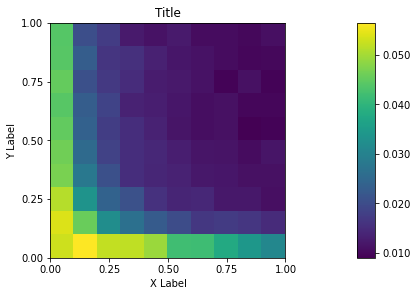

In [25]:
from matplotlib import pyplot as plt

errorarray = np.array(errorl2_list).reshape((10,10))



fig = plt.figure(constrained_layout=True)
nrows, ncols = 1, 2
w1, w2 = 20, 1
gspec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig, width_ratios=[w1, w2])

ax = plt.subplot(gspec[0, 0], aspect=w1)
ax.set_xlim(0, 1)
ax.set_xticks(np.linspace(0, 1, 4 + 1))
ax.set_xlabel("X Label")
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 4 + 1))
ax.set_ylabel("Y Label")
ax.set_title("Title", family="Roboto", weight=500)
I = ax.imshow(errorarray[::-1,:], extent=[0, 1, 0, 1])

ax = plt.subplot(gspec[0, 1], aspect='auto')
plt.colorbar(I, cax=ax,shrink=0.5,format='%.3f')

plt.show()

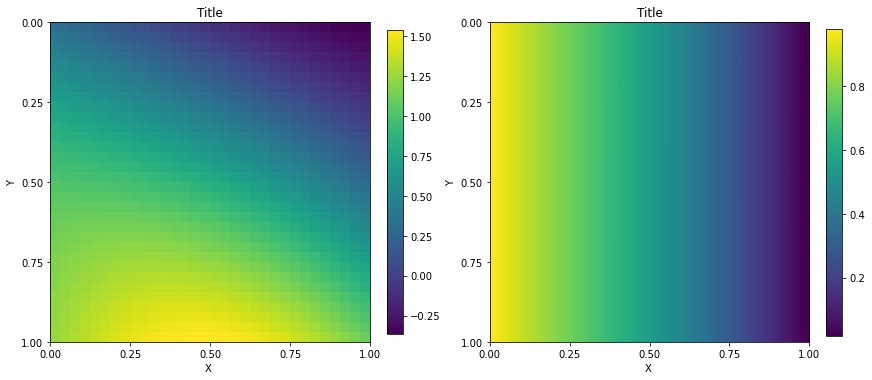

In [100]:
i = 99
j = 0
x= np.linspace(1/nx,1,100)
y= np.linspace(1/ny,1,100)
X,Y = np.meshgrid(x,y)
coord = np.stack((X,Y), axis=2).reshape(-1,2) 
Inputs=[]
for k in range(100*100):
    input = np.append(randomFiled_input,coord[k])
    Inputs.append(input)
pre_label = model.predict(np.array(Inputs))
pre_label = train_std_label*pre_label+train_mean_label
pre_label = pre_label.reshape((100,100))




x= np.linspace(1/nx,1,10)
y= np.linspace(1/ny,1,10)
X,Y = np.meshgrid(x,y)
coord = np.stack((X,Y), axis=2).reshape(-1,2) 


fig = plt.figure(figsize=(12,12),constrained_layout=True)
nrows, ncols = 1, 4
w1, w2 = 20, 1
gspec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig, width_ratios=[w1,w2,w1,w2])

ax = plt.subplot(gspec[0, 0], aspect=1)
ax.set_xlim(0, 1)
ax.set_xticks(np.linspace(0, 1, 4 + 1))
ax.set_xlabel("X ")
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 4 + 1))
ax.set_ylabel("Y")
ax.set_title("Title", family="Roboto", weight=500)
ax.invert_yaxis()
I = ax.imshow(Val_all_data[i]['randomfield_sample'][j], extent=[0, 1, 0, 1])
ax = plt.subplot(gspec[0, 1], aspect=w1//2)
plt.colorbar(I, cax=ax)


ax = plt.subplot(gspec[0, 2], aspect=1)
ax.set_xlim(0, 1)
ax.set_xticks(np.linspace(0, 1, 4 + 1))
ax.set_xlabel("X ")
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 4 + 1))
ax.set_ylabel("Y")
ax.set_title("Title", family="Roboto", weight=500)
ax.invert_yaxis()
I = ax.imshow(pre_label, extent=[0, 1, 0, 1])
ax = plt.subplot(gspec[0, 3], aspect=w1)
plt.colorbar(I, cax=ax)


plt.show()

# 不确定性量化

In [47]:
# 遍历所有的lengthscale 设置
i=0  # 选取第一个length scale对
k = 30 # 选取的坐标位置

lengthscale_pair = Val_all_data[i]['lengthscale_pair']
input_x = cellcenters[k]
print("length scale 为 ",lengthscale_pair)
print("空间坐标为 ",input_x)

length scale 为  [0.03125, 0.03125]
空间坐标为  [0.953125 0.015625]


In [48]:
Inputs =[]
for j in range(num_samples):
    
    randomFiled_input = Val_all_data[i]['randomfield_sample'][j].reshape((1,-1))
    outputs =Val_all_data[i]['outputs'][j].reshape((1,-1))  #FVM 计算出的值
    # outputs = (outputs-train_std_label)/train_std_label
    pre_label = []  #存储预测指数
    
    input = np.append(randomFiled_input,input_x)
    Inputs.append(input)
Inputs = np.array(Inputs,dtype=np.float32)
Inputs = torch.from_numpy(Inputs).cuda()
pre_label = MyModel(Inputs).detach().cpu().numpy()
pre_label = train_std_label*pre_label+train_mean_label
# one_errorl2=np.linalg.norm(pre_label.squeeze()-outputs.squeeze())/np.linalg.norm(outputs.squeeze())
# errorl2_Forlengthscale.append(one_errorl2)
# errorl2_list.append(np.mean(errorl2_Forlengthscale,axis=0))

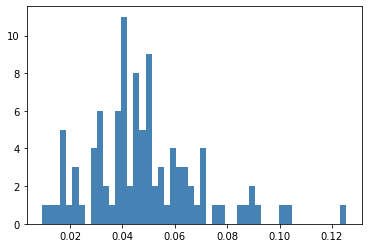

In [49]:

fre_tuple = plt.hist(pre_label, bins=50, color='steelblue') # 返回值元组
plt.show()

In [2]:
loss_list = joblib.load(os.path.join("/home/huangjg/MyFiles/deep-uq-paper/torch/pth","loss_list.pkl"))

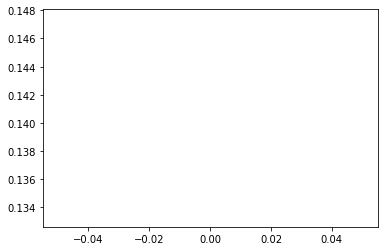

In [3]:
plt.plot(loss_list)
plt.show()

# 多保真结果测试

In [75]:
# 误差修正的方差和均值

high_mean,high_std  =joblib.load(os.path.join(datadir,k_+"_l_N_"+str(l_N)+"_num_samples_"+str(num_samples)+\
                    "_nx_"+str(nx)+"_ny_"+str(ny)+"_train_low.pkl"    ))['normal']
print(high_mean,high_std)

0.0005513662228722254 0.03950530089254518


In [76]:
# 模型加载
HModel = LossFNNSwish(1026,15,1)
save_model_name = k_+"_l_N_"+str(l_N)+"_num_samples_"+str(num_samples)+\
                    "_nx_"+str(nx)+"_ny_"+str(ny)+"_train_high_swish.pth"
HModel.load_state_dict(torch.load(os.path.join("/home/huangjg/MyFiles/deep-uq-paper/torch","pth",save_model_name)) ) #  保存模型参数)
HModel.cuda()
HModel.eval()

MyModel = FNN(1026,7,2)
save_model_name = k_+"_l_N_"+str(l_N)+"_num_samples_"+str(num_samples)+\
                    "_nx_"+str(nx)+"_ny_"+str(ny)+"_train.pth"
MyModel.load_state_dict(torch.load(os.path.join("/home/huangjg/MyFiles/deep-uq-paper/torch","pth",save_model_name)) ) #  保存模型参数)
MyModel.cuda()
MyModel.eval()

FNN(
  (seq_model): Sequential(
    (1): Linear(in_features=1026, out_features=421, bias=True)
    (1_Relu): ReLU()
    (2): Linear(in_features=421, out_features=173, bias=True)
    (2_Relu): ReLU()
    (3): Linear(in_features=173, out_features=71, bias=True)
    (3_Relu): ReLU()
    (4): Linear(in_features=71, out_features=30, bias=True)
    (4_Relu): ReLU()
    (5): Linear(in_features=30, out_features=12, bias=True)
    (5_Relu): ReLU()
    (6): Linear(in_features=12, out_features=5, bias=True)
    (6_Relu): ReLU()
    (7): Linear(in_features=5, out_features=3, bias=True)
    (8): Linear(in_features=3, out_features=600, bias=True)
    (8_Relu): ReLU()
    (9): Linear(in_features=600, out_features=1, bias=True)
  )
)

In [77]:
HModel

LossFNNSwish(
  (seq_model): Sequential(
    (1): Linear(in_features=1026, out_features=647, bias=True)
    (1_SILU): SiLU()
    (2): Linear(in_features=647, out_features=408, bias=True)
    (2_SILU): SiLU()
    (3): Linear(in_features=408, out_features=257, bias=True)
    (3_SILU): SiLU()
    (4): Linear(in_features=257, out_features=162, bias=True)
    (4_SILU): SiLU()
    (5): Linear(in_features=162, out_features=102, bias=True)
    (5_SILU): SiLU()
    (6): Linear(in_features=102, out_features=65, bias=True)
    (6_SILU): SiLU()
    (7): Linear(in_features=65, out_features=41, bias=True)
    (7_SILU): SiLU()
    (8): Linear(in_features=41, out_features=26, bias=True)
    (8_SILU): SiLU()
    (9): Linear(in_features=26, out_features=17, bias=True)
    (9_SILU): SiLU()
    (10): Linear(in_features=17, out_features=11, bias=True)
    (10_SILU): SiLU()
    (11): Linear(in_features=11, out_features=7, bias=True)
    (11_SILU): SiLU()
    (12): Linear(in_features=7, out_features=5, bias=

In [78]:
errorl2_list_low = []
errorl2_list_high = []
# 遍历所有的lengthscale 设置

for i in tqdm(range(100)):
    # 遍历每个lengthscale的采样例子
    errorl2_Forlengthscale_low=[]
    errorl2_Forlengthscale_high=[]
    for j in range(num_samples):
        Inputs =[]
        randomFiled_input = Val_all_data[i]['randomfield_sample'][j].reshape((1,-1))
        outputs =Val_all_data[i]['outputs'][j].reshape((1,-1))  #FVM 计算出的值
        # outputs = (outputs-train_std_label)/train_std_label
        pre_label = []  #存储预测指数
        for k in range(nx*ny):
            input = np.append(randomFiled_input,cellcenters[k])
            Inputs.append(input)
        Inputs = np.array(Inputs,dtype=np.float32)
        Inputs = torch.from_numpy(Inputs).cuda()
        pre_label = MyModel(Inputs).detach().cpu().numpy()
        pre_label = train_std_label*pre_label+train_mean_label
        pre_error = HModel(Inputs).detach().cpu().numpy()
        pre_error = high_std*pre_error+high_mean
        pre_res = pre_label +pre_error
        one_errorl2_high=np.linalg.norm(pre_res.squeeze()-outputs.squeeze())/np.linalg.norm(outputs.squeeze())
        one_errorl2_low=np.linalg.norm(pre_label.squeeze()-outputs.squeeze())/np.linalg.norm(outputs.squeeze())
        errorl2_Forlengthscale_low.append(one_errorl2_low)
        errorl2_Forlengthscale_high.append(one_errorl2_high)
    errorl2_list_low.append(np.mean(errorl2_Forlengthscale_low,axis=0))
    errorl2_list_high.append(np.mean(errorl2_Forlengthscale_high,axis=0))
    

100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


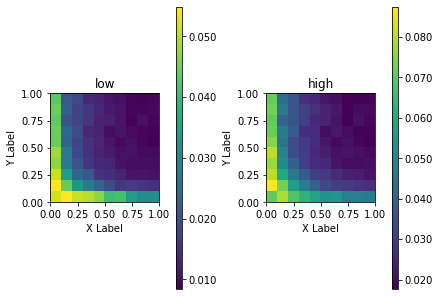

In [79]:
from matplotlib import pyplot as plt

errorarray_low = np.array(errorl2_list_low).reshape((10,10))
errorarray_high = np.array(errorl2_list_high).reshape((10,10))



fig = plt.figure(constrained_layout=True)
nrows, ncols = 1, 4
w1, w2 = 20, 1
gspec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig, width_ratios=[w1, w2,w1,w2])

ax = plt.subplot(gspec[0, 0], aspect=w1)
ax.set_xlim(0, 1)
ax.set_xticks(np.linspace(0, 1, 4 + 1))
ax.set_xlabel("X Label")
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 4 + 1))
ax.set_ylabel("Y Label")
ax.set_title("low", family="Roboto", weight=500)
I = ax.imshow(errorarray_low[::-1,:], extent=[0, 1, 0, 1])

ax = plt.subplot(gspec[0, 1], aspect='auto')
plt.colorbar(I, cax=ax,shrink=0.5,format='%.3f')

# 第二幅图片
ax = plt.subplot(gspec[0, 2], aspect=w1)
ax.set_xlim(0, 1)
ax.set_xticks(np.linspace(0, 1, 4 + 1))
ax.set_xlabel("X Label")
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 4 + 1))
ax.set_ylabel("Y Label")
ax.set_title("high", family="Roboto", weight=500)
I = ax.imshow(errorarray_high[::-1,:], extent=[0, 1, 0, 1])

ax = plt.subplot(gspec[0, 3], aspect='auto')
plt.colorbar(I, cax=ax,shrink=0.5,format='%.3f')

plt.show()

In [80]:
print(errorarray_low[0,0])
print(errorarray_high[0,0])

0.05169932616487915
0.07041644821683865


In [81]:
errorarray_high<errorarray_low

array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]])

# mutil tasks

In [87]:
lengthscale_pair_array_file = "lengthscale_pair_array.pkl"
lengthscale_pair_array = joblib.load(os.path.join(datadir,lengthscale_pair_array_file))


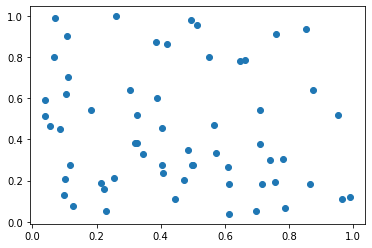

In [96]:
plt.scatter(lengthscale_pair_array[:,0],lengthscale_pair_array[:,1])

In [114]:
def Find_Recent(AllArray, TargetCor, k):
    """
    找到点集中距离目标点(x, y)最近的k个点
    :param x: 点集的x坐标
    :param y: 点集的y坐标
    :param x_: 目标点的x坐标
    :param y_: 目标点的y坐标
    :param k: 距离目标点最近的k个值
    :return: k个与目标点最近的点的集合
    """
    distance_list = []
    for i in range(AllArray.shape[0]):
        distance_list.append(np.linalg.norm(AllArray[i]-TargetCor))
    sorted_id = sorted(range(len(distance_list)), key=lambda k: distance_list[k], reverse=False)

    return sorted_id[:k]


TargetCor = np.array([0.5,0.5])
selectedList = Find_Recent(lengthscale_pair_array,TargetCor,5)

In [149]:


errorl2_list = []
Kmodel = 5  # 
# 遍历所有的lengthscale 设置

for i in tqdm(range(100)):
    # 遍历每个lengthscale的采样例子
    TargetCor = Val_all_data[i]['lengthscale_pair']
    selectedList = Find_Recent(lengthscale_pair_array,TargetCor,Kmodel)
    for k in range(Kmodel):
        selected_lengthscale_pair = lengthscale_pair_array[selectedList[k]]
        exec("model"+str(k)+"= FNN(1026,7,2)")
        exec("model"+str(k)+"= FNN(1026,7,2)")
        save_model_name = "meat_"+str(selected_lengthscale_pair[0])+"_"+str(selected_lengthscale_pair[1])+".pth"
        exec("model"+str(k)+".load_state_dict(torch.load(\"/home/huangjg/MyFiles/deep-uq-paper/meta_torch/MyReptile/pth/"+save_model_name+"\"))")
        exec("model"+str(k)+".cuda()")
        exec("model"+str(k)+".eval()")
    errorl2_Forlengthscale=[]
    for j in range(num_samples):
        Inputs =[]
        randomFiled_input = Val_all_data[i]['randomfield_sample'][j].reshape((1,-1))
        outputs =Val_all_data[i]['outputs'][j].reshape((1,-1))  #FVM 计算出的值
        for k in range(nx*ny):
            input = np.append(randomFiled_input,cellcenters[k])
            Inputs.append(input)
        Inputs = np.array(Inputs,dtype=np.float32)
        Inputs = torch.from_numpy(Inputs).cuda()
        # 
        exec("pre_label =model"+str(0)+"(Inputs).detach().cpu().numpy()/Kmodel")
        for k in range(1,Kmodel):
            exec("pre_label +=model"+str(k)+"(Inputs).detach().cpu().numpy()/Kmodel")
        pre_label = train_std_label*pre_label+train_mean_label
        one_errorl2=np.linalg.norm(pre_label.squeeze()-outputs.squeeze())/np.linalg.norm(outputs.squeeze())
        errorl2_Forlengthscale.append(one_errorl2)
    errorl2_list.append(np.mean(errorl2_Forlengthscale,axis=0))

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


In [161]:
# print(errorl2_list)
val_lengthscale_array  =[]
temp_list = []
for j in range(100):
    val_lengthscale_array.append(Val_all_data[j]['lengthscale_pair'])
    if errorl2_list[j] <0.05:
        temp_list.append(j) 
val_lengthscale_array = np.array(val_lengthscale_array)
print(val_lengthscale_array[temp_list])
# print(lengthscale_pair_array[selectedList])
print(train_mean_label,train_std_label)

[[0.89236111 0.13888889]
 [1.         0.13888889]
 [0.78472222 0.24652778]
 [0.89236111 0.24652778]
 [1.         0.24652778]
 [0.67708333 0.35416667]
 [0.78472222 0.35416667]
 [0.89236111 0.35416667]
 [1.         0.35416667]
 [0.56944444 0.46180556]
 [0.67708333 0.46180556]
 [0.78472222 0.46180556]
 [0.89236111 0.46180556]
 [1.         0.46180556]
 [0.56944444 0.56944444]
 [0.67708333 0.56944444]
 [0.78472222 0.56944444]
 [0.89236111 0.56944444]
 [1.         0.56944444]
 [0.56944444 0.67708333]
 [0.67708333 0.67708333]
 [0.89236111 0.67708333]
 [1.         0.67708333]
 [0.46180556 0.78472222]
 [0.56944444 0.78472222]
 [0.67708333 0.78472222]
 [0.78472222 0.78472222]
 [0.89236111 0.78472222]
 [1.         0.78472222]
 [0.46180556 0.89236111]
 [0.56944444 0.89236111]
 [0.67708333 0.89236111]
 [0.78472222 0.89236111]
 [0.89236111 0.89236111]
 [1.         0.89236111]
 [0.56944444 1.        ]
 [0.67708333 1.        ]
 [0.78472222 1.        ]
 [0.89236111 1.        ]
 [1.         1.        ]]

array([[0.89236111, 0.13888889],
       [1.        , 0.13888889],
       [0.78472222, 0.24652778],
       [0.89236111, 0.24652778],
       [1.        , 0.24652778],
       [0.67708333, 0.35416667],
       [0.78472222, 0.35416667],
       [0.89236111, 0.35416667],
       [1.        , 0.35416667],
       [0.56944444, 0.46180556],
       [0.67708333, 0.46180556],
       [0.78472222, 0.46180556],
       [0.89236111, 0.46180556],
       [1.        , 0.46180556],
       [0.56944444, 0.56944444],
       [0.67708333, 0.56944444],
       [0.78472222, 0.56944444],
       [0.89236111, 0.56944444],
       [1.        , 0.56944444],
       [0.56944444, 0.67708333],
       [0.67708333, 0.67708333],
       [0.89236111, 0.67708333],
       [1.        , 0.67708333],
       [0.46180556, 0.78472222],
       [0.56944444, 0.78472222],
       [0.67708333, 0.78472222],
       [0.78472222, 0.78472222],
       [0.89236111, 0.78472222],
       [1.        , 0.78472222],
       [0.46180556, 0.89236111],
       [0.

(0.0, 1.0)

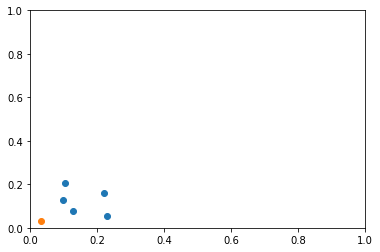

In [130]:
plt.scatter(lengthscale_pair_array[selectedList,0],lengthscale_pair_array[selectedList,1])
plt.scatter(TargetCor[0],TargetCor[1])
plt.xlim(0,1)#X轴范围
plt.ylim(0,1)#X轴范围

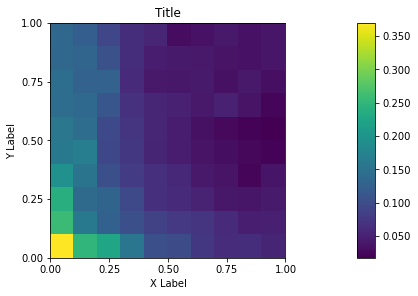

In [150]:



errorarray_meta = np.array(errorl2_list).reshape((10,10))



fig = plt.figure(constrained_layout=True)
nrows, ncols = 1, 2
w1, w2 = 20, 1
gspec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig, width_ratios=[w1, w2])

ax = plt.subplot(gspec[0, 0], aspect=w1)
ax.set_xlim(0, 1)
ax.set_xticks(np.linspace(0, 1, 4 + 1))
ax.set_xlabel("X Label")
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 4 + 1))
ax.set_ylabel("Y Label")
ax.set_title("Title", family="Roboto", weight=500)
I = ax.imshow(errorarray_meta[::-1,:], extent=[0, 1, 0, 1])

ax = plt.subplot(gspec[0, 1], aspect='auto')
plt.colorbar(I, cax=ax,shrink=0.5,format='%.3f')

plt.show()